## Import all needed libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

## Data Loading and Initial Inspection
First, we need to load the mental health dataset and understand its structure. This gives us a basic understanding of the data we're working with, including the number of samples, feature types, and potential issues.

In [6]:
# Load the dataset (make sure the file path is correct)
data = pd.read_csv("docs/mental_health_data.csv")

# Display the first few rows
print(data.head())

# Check basic information about the dataset
print(data.info())

# Get summary statistics
print(data.describe())

   User_ID  Age             Gender   Occupation    Country  \
0        1   36               Male    Education  Australia   
1        2   48               Male  Engineering      Other   
2        3   18  Prefer not to say        Sales      India   
3        4   30         Non-binary  Engineering  Australia   
4        5   58               Male           IT        USA   

  Mental_Health_Condition Severity Consultation_History Stress_Level  \
0                     Yes      NaN                  Yes          Low   
1                      No      Low                   No          Low   
2                      No      NaN                  Yes       Medium   
3                      No   Medium                   No          Low   
4                     Yes      NaN                  Yes         High   

   Sleep_Hours  Work_Hours  Physical_Activity_Hours  Social_Media_Usage  \
0          7.6          46                        8                 2.2   
1          6.8          74                  

## Handling Missing Values
Missing data can significantly impact model performance. Here we check for missing values and handle them appropriately. For numerical features, we use the median, while for categorical features, we use the mode (most frequent value).

In [7]:
# Check for missing values
print(data.isnull().sum())

# For numerical columns, fill missing values with the median
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# For categorical columns, fill missing values with the mode
cat_cols = data.select_dtypes(include=["object"]).columns
for col in cat_cols:
    # Exclude the "Severity" column because "None" is a valid value
    if col == "Severity":
        data[col] = data[col].fillna("None")
    else:
        data[col] = data[col].fillna(data[col].mode()[0])

# Verify that missing values are handled
print(data.isnull().sum())

User_ID                        0
Age                            0
Gender                         0
Occupation                     0
Country                        0
Mental_Health_Condition        0
Severity                   25002
Consultation_History           0
Stress_Level                   0
Sleep_Hours                    0
Work_Hours                     0
Physical_Activity_Hours        0
Social_Media_Usage             0
Diet_Quality                   0
Smoking_Habit                  0
Alcohol_Consumption            0
Medication_Usage               0
dtype: int64
User_ID                    0
Age                        0
Gender                     0
Occupation                 0
Country                    0
Mental_Health_Condition    0
Severity                   0
Consultation_History       0
Stress_Level               0
Sleep_Hours                0
Work_Hours                 0
Physical_Activity_Hours    0
Social_Media_Usage         0
Diet_Quality               0
Smoking_Habit       

## Outlier Detection and Handling
Outliers can distort statistical measures and affect model performance. We visualize numerical features to identify potential outliers and then handle them using the capping method (limiting values to within a certain range based on the IQR).

<Figure size 1200x800 with 0 Axes>

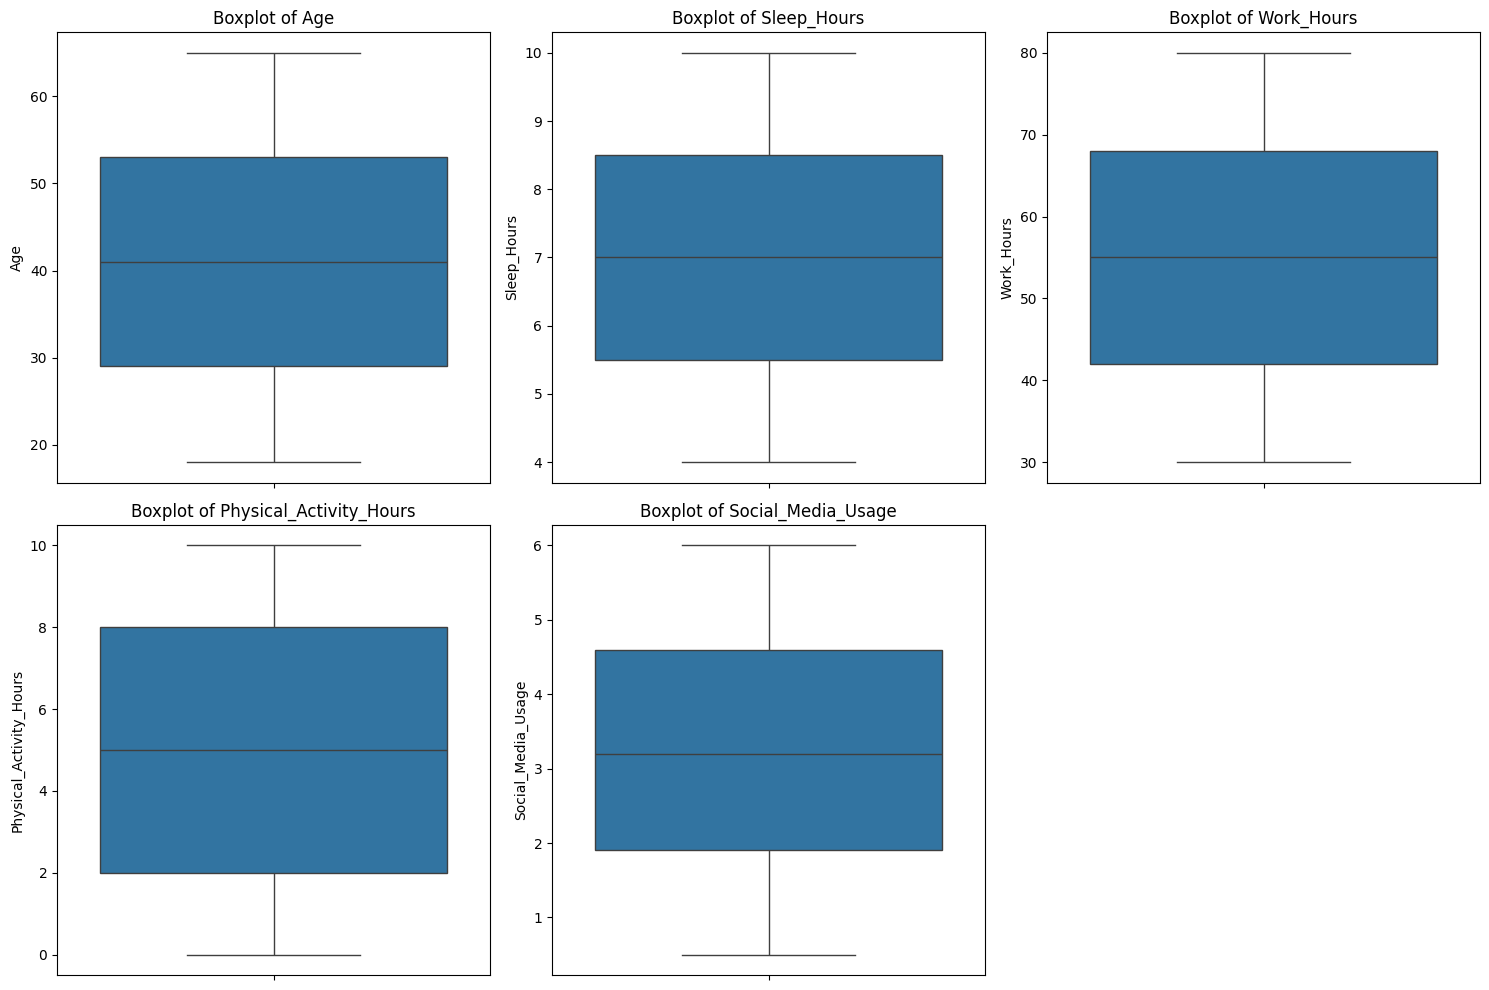

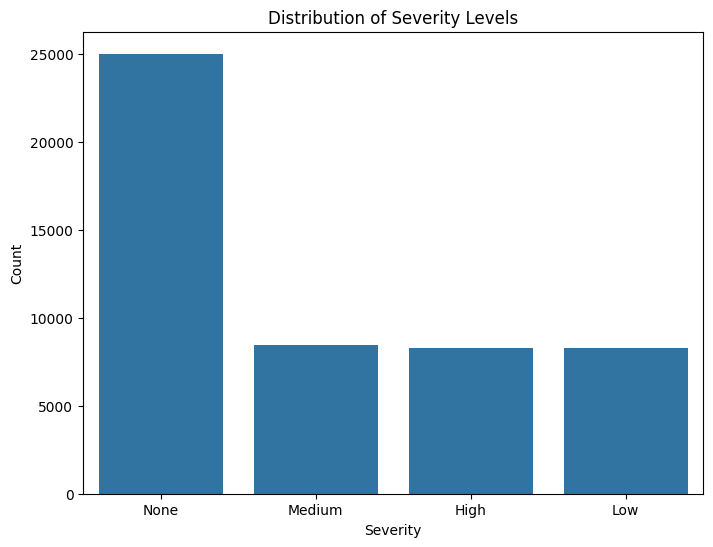

In [8]:
# Visualize numerical features to detect outliers
plt.figure(figsize=(12, 8))

# Create a subplot for several numerical features
numerical_cols = [
    "Age",
    "Sleep_Hours",
    "Work_Hours",
    "Physical_Activity_Hours",
    "Social_Media_Usage",
]
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

plt.show()

# Check the distribution of the Severity column (our target)
plt.figure(figsize=(8, 6))
severity_counts = data["Severity"].value_counts()
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.title("Distribution of Severity Levels")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()


# Handle outliers in numerical columns using capping
for col in ["Work_Hours", "Sleep_Hours", "Social_Media_Usage"]:
    # Calculate Q1, Q3 and IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])

## Feature Engineering
Feature engineering is crucial for improving model performance. We create new features that might better capture the relationships in the data. Here we convert the target to numeric values and create derived features that might better predict anxiety severity.

Unique values in Severity column: ['None' 'Low' 'Medium' 'High']


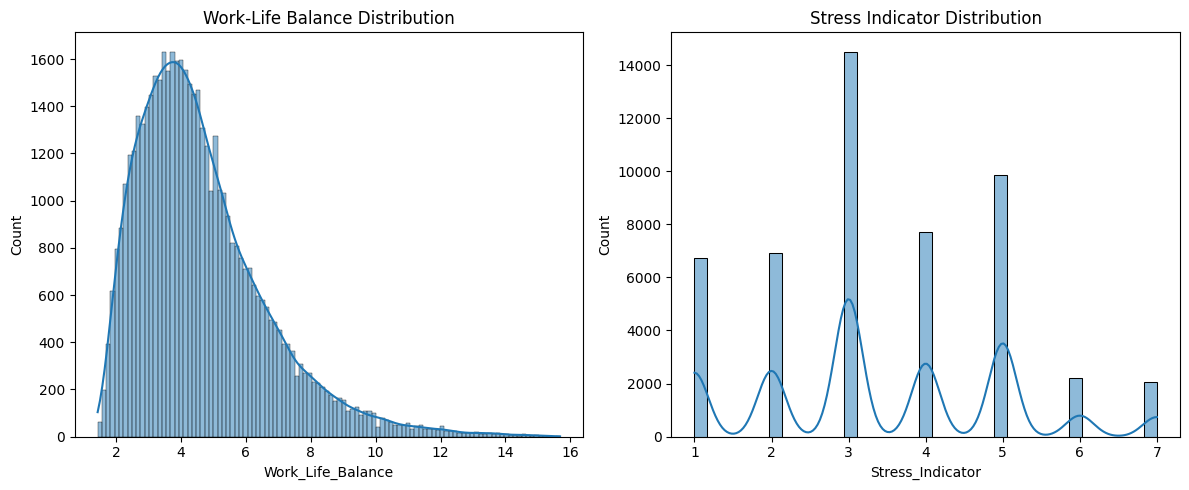

Correlation between Stress_Indicator and Severity_Numeric: -0.003249489997436482


In [9]:
# Examine Severity column values
print("Unique values in Severity column:", data["Severity"].unique())

# Convert Severity to ordinal values
severity_mapping = {
    "None": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3,
}
data["Severity_Numeric"] = data["Severity"].map(severity_mapping)

# Create feature for work-life balance (ratio of work hours to sleep + physical activity)
data["Work_Life_Balance"] = data["Work_Hours"] / (
    data["Sleep_Hours"] + data["Physical_Activity_Hours"] + 1
)  # +1 to avoid division by zero

# Create stress indicator based on multiple factors
data["Stress_Indicator"] = (
    (data["Stress_Level"] == "High").astype(int) * 3
    + (data["Stress_Level"] == "Medium").astype(int) * 2
    + (data["Stress_Level"] == "Low").astype(int) * 1
    + (data["Work_Hours"] > 60).astype(int) * 2
    + (data["Sleep_Hours"] < 6).astype(int) * 2
)

# Visualize new features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data["Work_Life_Balance"], kde=True)
plt.title("Work-Life Balance Distribution")

plt.subplot(1, 2, 2)
sns.histplot(data["Stress_Indicator"], kde=True)
plt.title("Stress Indicator Distribution")
plt.tight_layout()
plt.show()

print(
    "Correlation between Stress_Indicator and Severity_Numeric:",
    data["Stress_Indicator"].corr(data["Severity_Numeric"]),
)

### Creating Interaction Terms
Interaction terms capture the combined effect of multiple features, which can be more informative than individual features alone. We create interactions between stress levels and sleep hours, as well as between work hours and physical activity.

In [10]:
# Create interaction terms between important features
data["Stress_Sleep_Interaction"] = data["Stress_Indicator"] * (10 - data["Sleep_Hours"])
data["Work_Activity_Ratio"] = data["Work_Hours"] / (data["Physical_Activity_Hours"] + 1)

# Add these to numerical_cols
numerical_cols.extend(["Stress_Sleep_Interaction", "Work_Activity_Ratio"])

## Exploratory Data Analysis
Before building models, it's important to understand the relationships between features and the target. We visualize how different categorical and numerical features relate to anxiety severity.

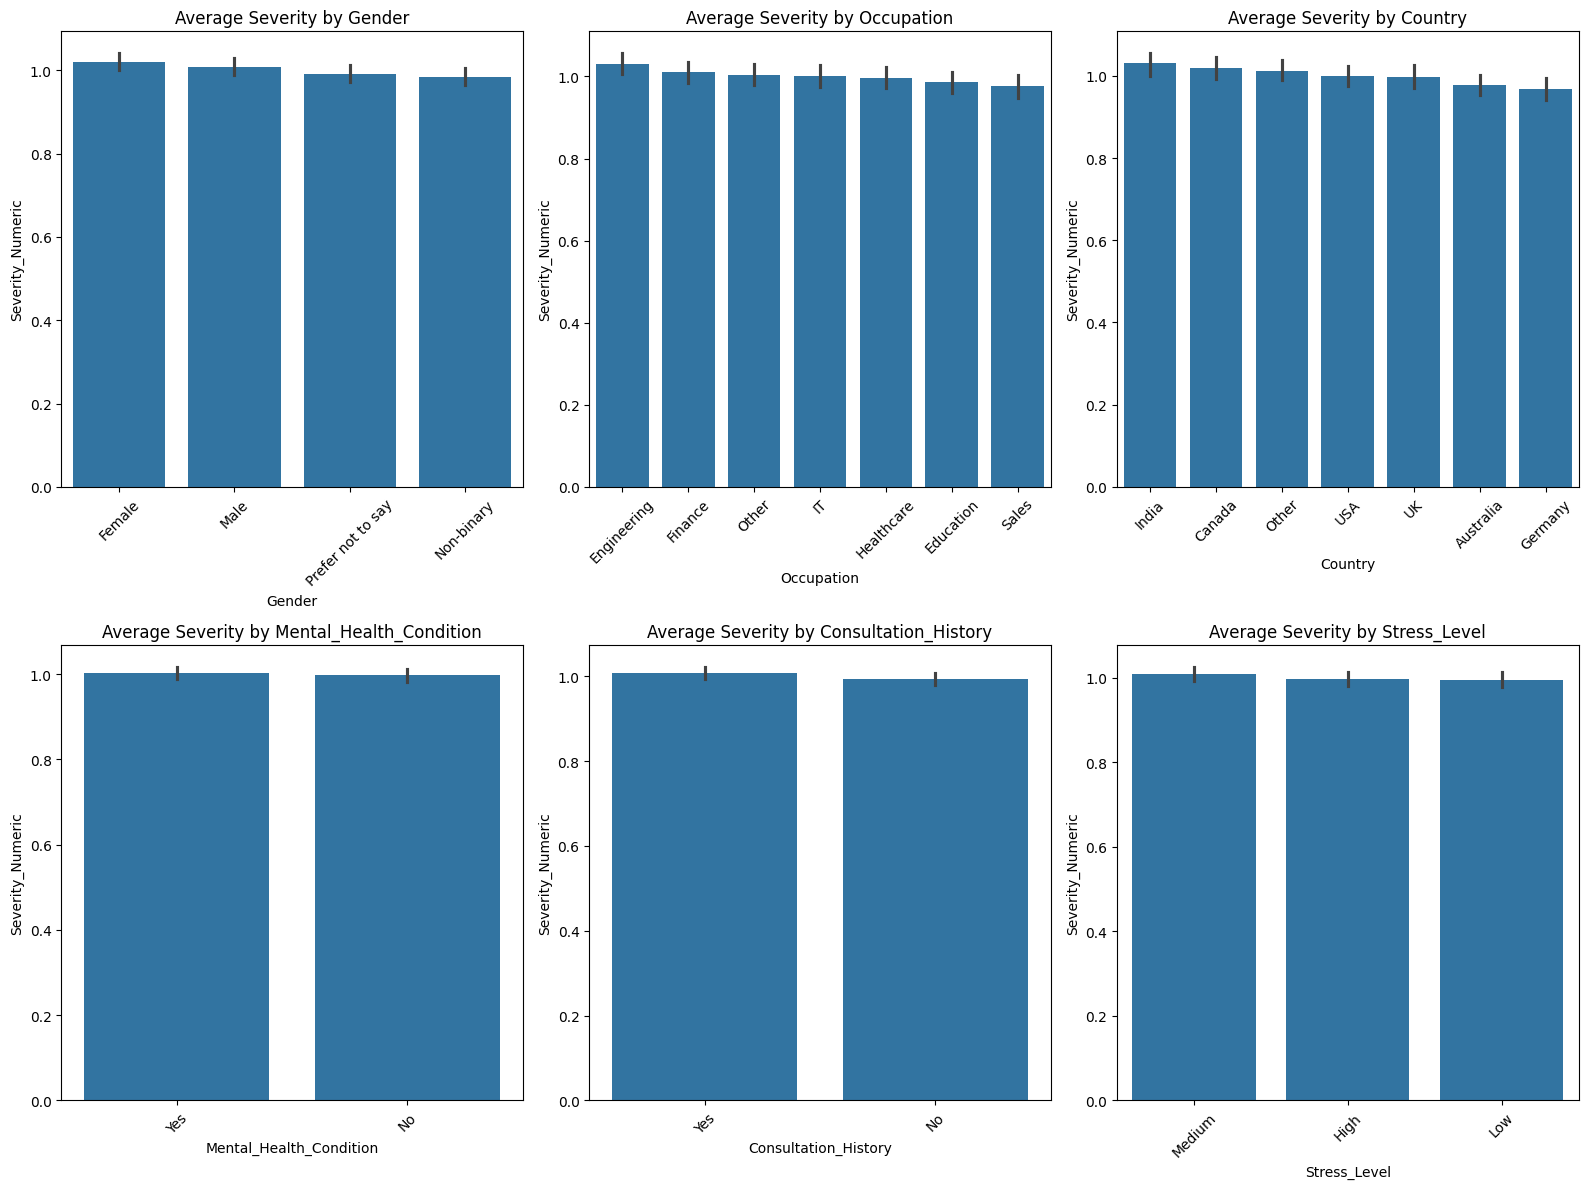

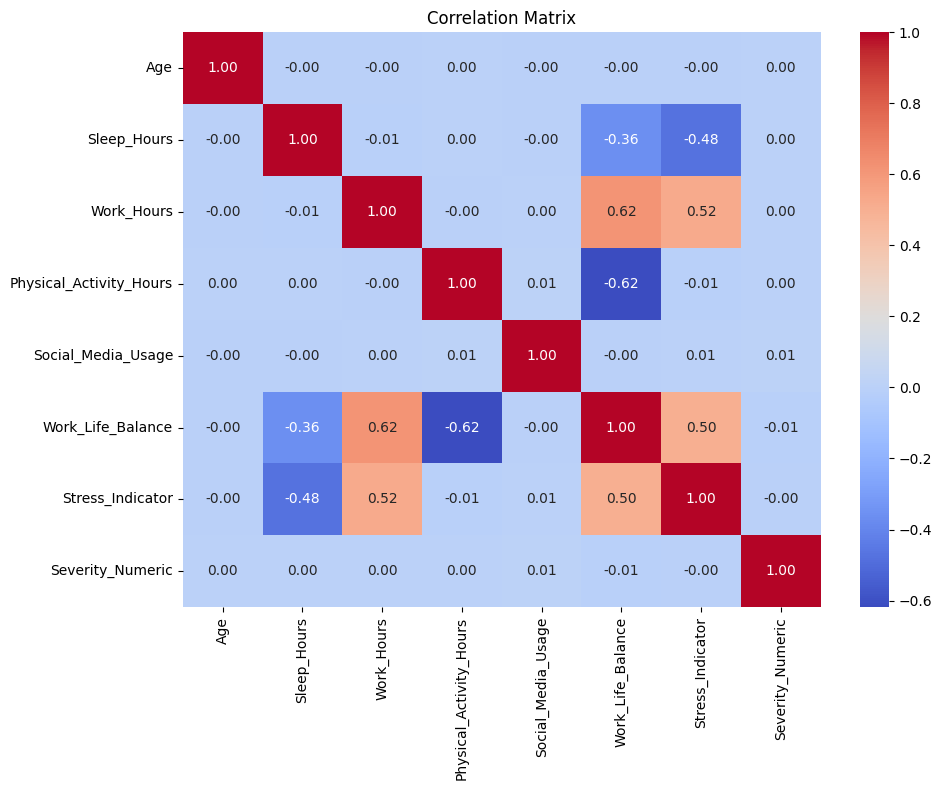

In [11]:
# Identify categorical and numerical columns
categorical_cols = [
    "Gender",
    "Occupation",
    "Country",
    "Mental_Health_Condition",
    "Consultation_History",
    "Stress_Level",
    "Diet_Quality",
    "Smoking_Habit",
    "Alcohol_Consumption",
    "Medication_Usage",
]

numerical_cols = [
    "Age",
    "Sleep_Hours",
    "Work_Hours",
    "Physical_Activity_Hours",
    "Social_Media_Usage",
    "Work_Life_Balance",
    "Stress_Indicator",
]

# Visualize relationships between categorical features and severity
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols[:6]):  # Show first 6 to keep plot manageable
    plt.subplot(2, 3, i + 1)
    order = (
        data.groupby(col)["Severity_Numeric"].mean().sort_values(ascending=False).index
    )
    sns.barplot(x=data[col], y=data["Severity_Numeric"], order=order)
    plt.title(f"Average Severity by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = data[numerical_cols + ["Severity_Numeric"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Data Preparation for Modeling
We prepare the data for machine learning by splitting it into training and testing sets and creating a preprocessing pipeline. This ensures consistent treatment of features and prevents data leakage.

In [12]:
# Drop User_ID as it's not relevant for modeling
data = data.drop("User_ID", axis=1)

# Prepare data for modeling
X = data.drop(["Severity", "Severity_Numeric"], axis=1)
y = data["Severity_Numeric"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Create preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Preview the transformed data
preprocessor.fit(X_train)
print(
    "Number of features after preprocessing:",
    preprocessor.transform(X_train[:1]).shape[1],
)

Number of features after preprocessing: 45


## Feature Selection
Not all features contribute equally to predicting the target. We identify the most important features using a Random Forest model, which can help us understand what factors are most associated with anxiety severity and potentially simplify our model.

Top 10 most important features:
                              Feature  Importance
5                   Work_Life_Balance    0.136678
0                                 Age    0.104786
4                  Social_Media_Usage    0.103944
1                         Sleep_Hours    0.102188
2                          Work_Hours    0.088890
3             Physical_Activity_Hours    0.047937
6                    Stress_Indicator    0.026896
39  Alcohol_Consumption_Heavy Drinker    0.012146
40    Alcohol_Consumption_Non-Drinker    0.012002
37    Smoking_Habit_Occasional Smoker    0.011627


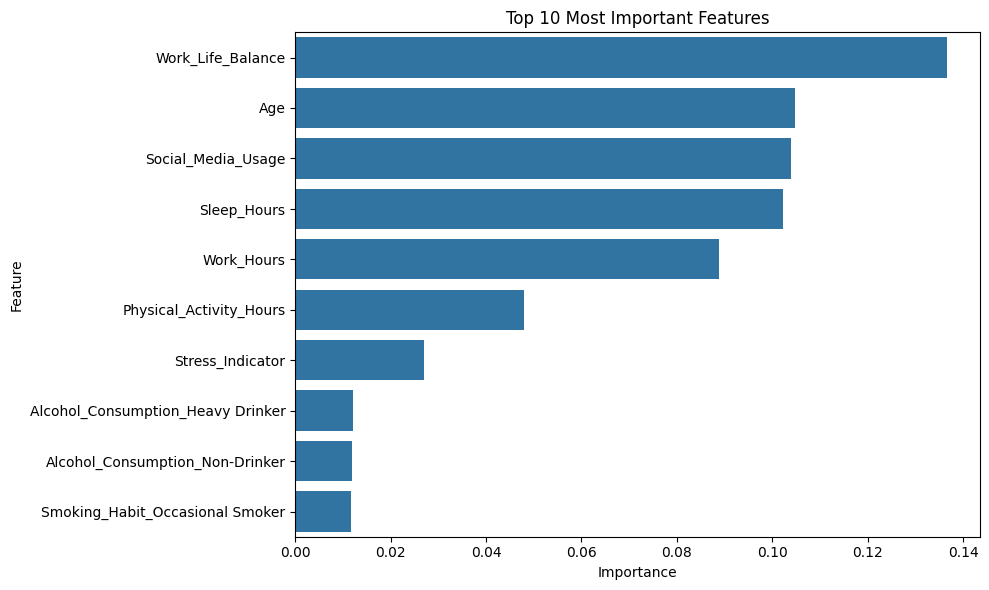

In [13]:
# Train a simple model to get feature importance
X_preprocessed = preprocessor.fit_transform(X_train)
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
feature_selector.fit(X_preprocessed, y_train)

# Get feature names after preprocessing
ohe_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(
    categorical_cols
)
feature_names = numerical_cols + list(ohe_feature_names)

# Display feature importance
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_selector.feature_importances_}
)
feature_importance = feature_importance.sort_values("Importance", ascending=False)
print("Top 10 most important features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()

## Class Imbalance Analysis
Imbalanced classes can lead to biased models. We check if our target classes (anxiety severity levels) are balanced and calculate class weights to address any imbalance during model training.

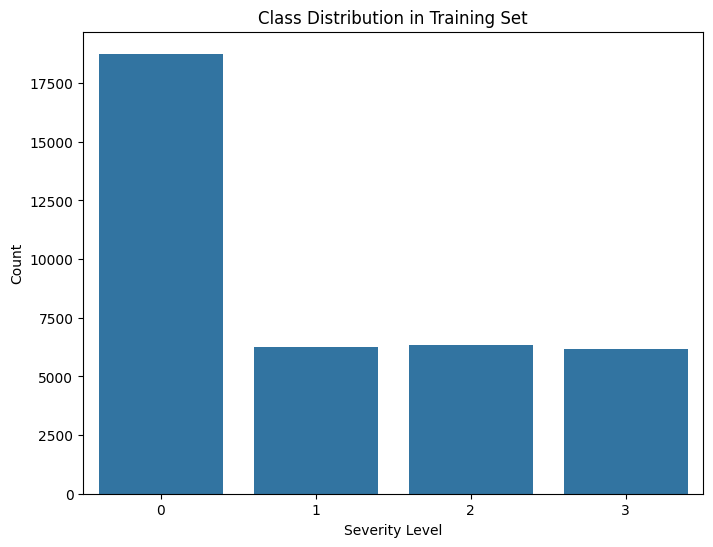

Class weights: {0: np.float64(0.49994667235494883), 1: np.float64(1.5004801536491676), 2: np.float64(1.484090549311382), 3: np.float64(1.5162542455118875)}
Preprocessing complete. Ready for modeling!


In [ ]:
# Check for class imbalance
plt.figure(figsize=(8, 6))
class_counts = y_train.value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution in Training Set")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

# Calculate class weights if imbalanced
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# Now the data is ready for model building
print("Preprocessing complete")